In [1]:
import sys
sys.path.append("..")

In [2]:
# Setup
import reproducibility

# both can change
# Environment
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import tensorflow as tf
import pickle, os

C:\Users\jhirs\anaconda3\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


# Physics-Initiated Neural Networks - Output Layers

The purpose of this notebook is to discuss the final output layer of physics-initiated Neural Networks. Physics might constrain the range of model outputs, so it might make sense to hard-code this into the output layer. Furthermore, a physical system may have different behavior when it approaches the minimum and maximum allowable values.

## Fuel Moisture Models

In the fuel moisture content (FM) modeling framework, there are constraints on the model outputs to make it physically reasonable. First, FM cannot go below 0%, when there is no water content in the fuels. The maximum possible water content depends on the fuel type. Live fuels range from 200-250% maximum allowable moisture. For dead fuels, Mandel et.al. 2014 use the model below with a "saturation" moisture level $S=250\%$:


$$
\frac{\mathrm{d}m}{\mathrm{d}t}=\frac{S-m}{t_{\mathrm{r}}}\left(1-\exp\left(-\frac{r-r_0}{r_{\mathrm{s}}}
\right)  \right),\ \text{if}\ r>r_0, 
$$

A simple approach would be to constrain the outputs with a piece-wise linear function, or a "clipped relu" function as depicted below:

![activation functions](https://www.researchgate.net/profile/Md-Hossain-331/publication/343096012/figure/fig2/AS:915583516278784@1595303529166/Activation-Functions-f-x-and-their-corresponding-1-st-derivatives-Dx-The-proposed.png)

For the purposes of this notebook, we will constrain dead fuel moisture values to be less than or equal to 250%. Additionally, a physically reasonable process would have moisture content approach the maximum logarithmically, but the minimum moisture content of 0% could be reached more easily. Thus, the "log-tailed relu" depicted above would be the most reasonable physical model.

Sources:
* [Live Fuel Moistures](https://www.nwcg.gov/publications/pms437/fuel-moisture/live-fuel-moisture-content)
* [Fuel Moisture Processes](https://www.nwcg.gov/publications/pms425-1/weather-and-fuel-moisture), includes discussion of fiber-saturation level

## Clipped and Log-Tailed Relu Functions

Below we define the activation functions and plot the range.

In [13]:
# Define clipped ReLU function
def clipped_relu(x):
    return tf.keras.backend.minimum(tf.keras.backend.maximum(0., x), 250.)

In [27]:
xgrid = np.linspace(-100, 400, 50)

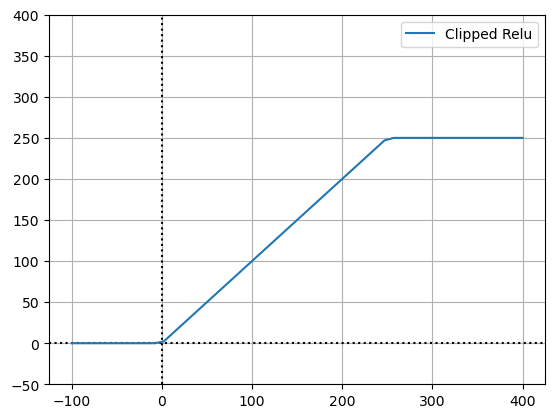

In [28]:
plt.ylim(-50, 400)
plt.axline((-1, 0), (0, 0), color="k", linestyle=":") # x axis line
plt.axline((0, 0), (0, 1), color="k", linestyle=":") # y axis line
plt.plot(xgrid, clipped_relu(xgrid), label = "Clipped Relu")
plt.legend()
plt.grid()